# SVM

SVM은 데이터들을 분류하기 위해 **최적의 결정 경계선(초평면)**을 찾음

2차원에서는 직선, 3차원 이상에서는 평면 또는 초평면이라고 부름

두 그룹 사이를 가장 멀리 떨어지게 나누는 최적의 선


# 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load_dataset을 사용해 데이터프레임으로 변환
df = sns.load_dataset('titanic')

In [3]:
# 중복데이터 확인
df.duplicated().sum()

np.int64(107)

In [4]:
# Nan 값이 많은 deck열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck','embark_town'], axis=1)
rdf.columns.values

array(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'alive', 'alone'],
      dtype=object)

In [5]:
# age 열에 나이 데이터가 없는 모든 행 삭제
# how='any': 하나라도 결측값이 있으면 해당 행을 제거
rdf = rdf.dropna(subset=['age'], how='any', axis=0)

In [6]:
# embarked 열의 Nan 값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
# drop=True: Nan 값은 drop
# idxmax(): 빈도수가 높은 값 반환
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()
print(most_freq)

S


In [7]:
# 분석에 활용할 열 선택
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]
ndf.head()

,survived,pclass,sex,age,sibsp,parch,embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [8]:
# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

# prefix: 컬럼 앞에 붙일 접두사, 'S', 'C', 'Q' → town_S, town_C, town_Q
onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

# 기존의 sex, embarked 열 지우기
ndf = ndf.drop(['sex','embarked'], axis=1)
ndf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,False,True,False,False,True
1,1,1,38.0,1,0,True,False,True,False,False
2,1,3,26.0,0,0,True,False,False,False,True
3,1,1,35.0,1,0,True,False,False,False,True
4,0,3,35.0,0,0,False,True,False,False,True


In [9]:
# 속성 변수 선택
X = ndf[['pclass','age','sibsp','parch','female','male','town_C','town_Q','town_S']] # 설명변수 X
y = ndf[['survived']] # 예측 변수 y

In [10]:
# 설명 변수 데이터를 정규화 (normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data와 test data를 7:3으로 구분
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

print('train data 개수:', X_train.shape)
print('test data 개수:', X_test.shape)

train data 개수: (499, 9)
test data 개수: (215, 9)


# 모델 학습 및 검증

In [13]:
# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn import svm

# 모형 객체 생성(kernel='rbf' 적용)
# 데이터를 벡터 공간으로 매핑하는 함수
svm_model = svm.SVC(kernel='rbf')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)

# test data를 가지고 y_hat 예측(분류)
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 0 1 0 0 0 1 0 0 0]
[[0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
# 모델 성능 평가 - Confusion Matrix 계산
from sklearn import metrics
svm_matrix = metrics.confusion_matrix(y_test, y_hat)
print(svm_matrix)

[[120   5]
 [ 35  55]]


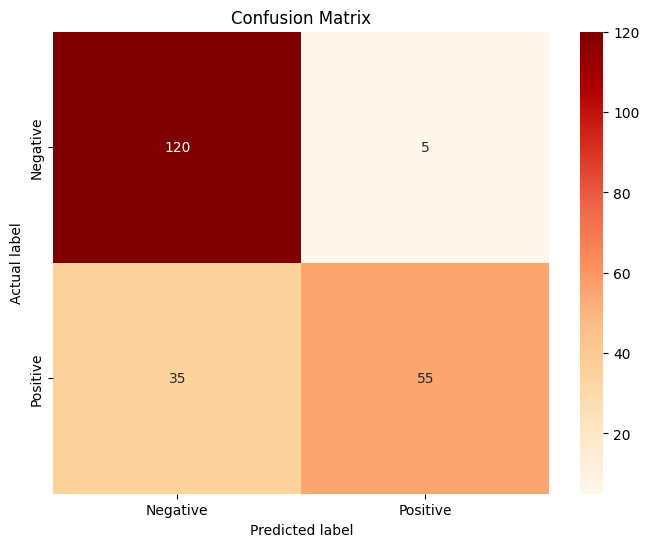

In [15]:
# Confusion Matrix 시각화
# annot=True: 각 셀에 숫자값(정수)을 표시
# fmt='d': 포맷 정수로 입력
plt.figure(figsize=(8, 6))
sns.heatmap(svm_matrix, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
# 모델 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)
print(svm_report)

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       125
           1       0.92      0.61      0.73        90

    accuracy                           0.81       215
   macro avg       0.85      0.79      0.80       215
weighted avg       0.83      0.81      0.81       215

